Convolutional Neural Network for Covid-19 detection from X-ray images
===========

Packages

In [1]:
from tqdm import tqdm
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as tt
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import imageio
import glob
from skimage.transform import rescale, resize, downscale_local_mean
from torch.utils.data import Dataset, DataLoader

Parameters

In [2]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print("Using device:",device)
print(torch.cuda.get_device_name(0))
#torch.cuda.set_per_process_memory_fraction(0.95, device)

batch_size = 64
lr=0.0002
mu1 = 0.5
mu2 = 0.999

Using device: cuda
NVIDIA GeForce GTX 1060 3GB


Load Data
----------

In [8]:
traindata=[]
testdata=[] 

d_covid = "data\COVID_data\COVID"
d_normal = r"data\Normal_data\Normal"

fraction_original = 16  #Since we wanted to test the Result with different fractions of real and generated data 
fraction_generated = 8  #we introduced tese variables


#Load training images
#Here we can load the wanted amount of real and generated images (according to the wanted fraction) into the training set
i = 0
for im_path in glob.glob('data\COVID_data_GENERATED\GENERATED\*.png'):
     if i < 5000/fraction_generated:
          traindata.append(list([torch.Tensor([resize(imageio.imread(im_path),(128,128),anti_aliasing=True)]),1]))
     i += 1
i = 0
for im_path in glob.glob(r'data\Normal_data_GENERATED\GENERATED\*.png'):
     if i < 5000/fraction_generated:
          traindata.append(list([torch.Tensor([resize(imageio.imread(im_path),(128,128),anti_aliasing=True)]),0]))
     i += 1
i = 0
for im_path in glob.glob('data\COVID_data\COVID\*.png'):
     if i < 3000/fraction_original:
          traindata.append(list([torch.Tensor([resize(imageio.imread(im_path),(128,128),anti_aliasing=True)]),1]))
     i += 1
i = 0
for im_path in glob.glob(r'data\Normal_data\Normal\*.png'):
     if i < 8000/fraction_original:
          traindata.append(list([torch.Tensor([resize(imageio.imread(im_path),(128,128),anti_aliasing=True)]),0]))
     i += 1


#Load Test images
for im_path in glob.glob('data\COVID_data_TEST\TEST\*.png'):
     testdata.append(list([torch.Tensor([resize(imageio.imread(im_path),(128,128),anti_aliasing=True)]),1]))
for im_path in glob.glob(r'data\Normal_data_TEST\TEST\*.png'):
     testdata.append(list([torch.Tensor([resize(imageio.imread(im_path),(128,128),anti_aliasing=True)]),0]))

Define Dataloader

In [10]:
# Create data loaders.
test_dataloader = DataLoader(testdata, batch_size, shuffle=True, pin_memory=True)
train_dataloader= DataLoader(traindata, batch_size, shuffle=True, pin_memory=True)


for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 128, 128])
Shape of y:  torch.Size([64]) torch.int64


Plot an image of each class

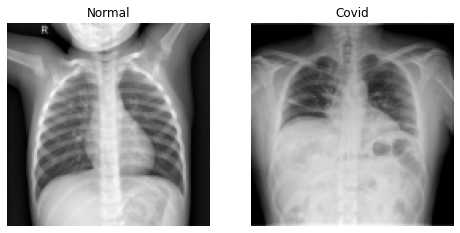

In [12]:
labels_map = {0: "Normal",1: "Covid"}
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(traindata), size=(1,)).item()
    img, label = traindata[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

CNN Model
----

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.model = nn.Sequential(

            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),

            nn.Linear(18432,512), 
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 2),
        ).to(device)
        
        
    def forward(self, x):
        return self.model(x)

cnn = CNN().to(device)
summary(cnn, (1, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             320
              ReLU-2         [-1, 32, 126, 126]               0
            Conv2d-3         [-1, 64, 124, 124]          18,496
              ReLU-4         [-1, 64, 124, 124]               0
         MaxPool2d-5           [-1, 64, 62, 62]               0
            Conv2d-6          [-1, 128, 60, 60]          73,856
              ReLU-7          [-1, 128, 60, 60]               0
         MaxPool2d-8          [-1, 128, 30, 30]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
             ReLU-10          [-1, 256, 28, 28]               0
        MaxPool2d-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 512, 12, 12]       1,180,160
             ReLU-13          [-1, 512, 12, 12]               0
        MaxPool2d-14            [-1, 51

Training/Optimizing algorithm
--------

Loss and optimizer

In [39]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(),lr=lr, betas=(mu1, mu2))

Functions which train, test and calculate errors

In [40]:
def train(dataloader, model, loss, optimizer):

    size = len(dataloader.dataset)
    loss_vals_sum = 0 # Loss
    correct = 0 # Accuracy

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X) # Compute predictions
        train_loss = loss(pred, y) # Calculate loss
        optimizer.zero_grad()
        train_loss.backward() # Backpropagation
        optimizer.step() # Update network

        # Store loss and accuracy
        loss_vals_sum += train_loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    return loss_vals_sum, 100*(correct/size)

def test(dataloader, model, loss):
    y_pred=[] # Predicted labels
    y_true=[] # true labels
    test_loss, correct = 0, 0 # Loss and Accuracy
    size = len(dataloader.dataset)

    model.eval() # Evaluation Mode -> Dropout probability = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # Prediction
            test_loss += loss(pred, y).item() # Calculate loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() #Accuracy

            y_pred.append(pred)
            y_true.append(y)
    correct /= size

    return 100*correct, test_loss, y_pred, y_true

Run network

In [41]:
epochs = 50

loss_vals = np.zeros(epochs)
loss_vals_accuracy = np.zeros(epochs)

loss_vals_test = np.zeros(epochs)
loss_vals_test_accuracy = np.zeros(epochs)

for t in tqdm(range(epochs)):
    loss_vals[t], loss_vals_accuracy[t] = train(train_dataloader, cnn, loss, optimizer)
    loss_vals_test_accuracy[t], loss_vals_test[t], _, _ = test(test_dataloader,cnn,loss)

print(f"Test \nAccuracy: {(test(test_dataloader,cnn)[0]):>0.1f}%, Avg loss: {test(test_dataloader,cnn)[1]:>8f} \n")
print("Done!")

 56%|█████▌    | 28/50 [03:55<03:07,  8.54s/it]

Print results

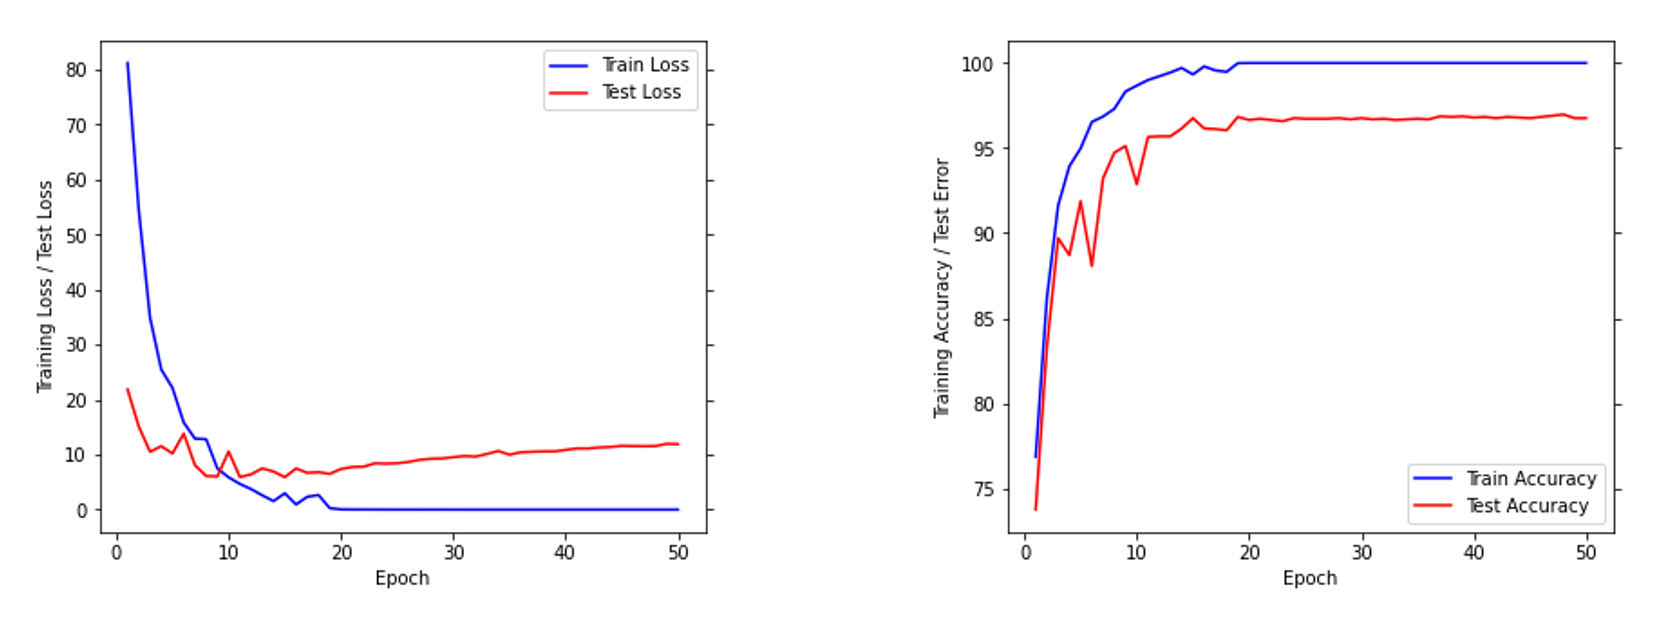

<Figure size 1080x360 with 0 Axes>

In [14]:
plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.plot(np.linspace(1,epochs,epochs),loss_vals,c="blue",label="Train Loss")
plt.plot(np.linspace(1,epochs,epochs),loss_vals_test,c="red",label="Test Loss")
plt.ylabel("Training Loss / Test Loss")
plt.xlabel("Epoch")
plt.yticks()
plt.title(f"Training/Test Loss evolution, Original/Synthetic Data: \n ({percent_original}%/{percent_generated}%)")
plt.tick_params(right=True, top=False, labelright=False, labeltop=False)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.linspace(1,epochs,epochs),loss_vals_accuracy,c="blue",label="Train Accuracy")
plt.plot(np.linspace(1,epochs,epochs),loss_vals_test_accuracy,c="red",label="Test Accuracy")
plt.ylabel("Training Accuracy / Test Error")
plt.xlabel("Epoch")
plt.title(f"Training/Test Accuracy evolution, Original/Synthetic Data: \n ({percent_original}%/{percent_generated}%)")
plt.tick_params(right=True, top=False, labelright=False, labeltop=False)
plt.legend()

plt.show()